# Semi-supervised surgery pipeline with SCANVI

In [1]:
import os
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np
import gdown

from scarches.dataset.trvae.data_handling import remove_sparsity

Global seed set to 0


In [3]:
cache_dir = 'cache/'
os.makedirs(cache_dir, exist_ok=True)
os.chdir(cache_dir)

data_output = 'pancreas.h5ad'
vae_dir = 'vae_model'
ref_dir = 'ref_model'
surgery_dir = 'surgery_model'

load_existing_model = True

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas.

In [5]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2']

### Download Dataset and split into reference dataset and query dataset

In [6]:
if not os.path.exists(data_output):
    url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
    gdown.download(url, data_output, quiet=False)

In [7]:
adata_all = sc.read(data_output)

This line makes sure that count data is in the adata.X. Remember that count data in adata.X is necessary when using "nb" or "zinb" loss.

In [8]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata[adata.obs[condition_key].isin(target_conditions)].copy()

In [9]:
source_adata

AnnData object with n_obs × n_vars = 10294 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [10]:
target_adata

AnnData object with n_obs × n_vars = 5387 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [11]:
def display_umap(matrix, color=None, frameon=False, wspace=0.6):
    sc.pp.neighbors(matrix)
    sc.tl.leiden(matrix)
    sc.tl.umap(matrix)
    plt.figure()
    sc.pl.umap(
        matrix,
        color=color,
        frameon=frameon,
        wspace=wspace,
    )

### Create SCANVI model and train it on fully labelled reference dataset

Preprocess reference dataset. Remember that the adata file has to have count data in adata.X for SCVI/SCANVI if not further specified

In [12]:
sca.dataset.setup_anndata(source_adata, batch_key=condition_key, labels_key=cell_type_key)

INFO     Using batches from adata.obs["study"]                                               
INFO     Using labels from adata.obs["cell_type"]                                            
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 10294 cells, 1000 vars, 3 batches,
         8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [13]:
if load_existing_model and os.path.exists(vae_dir):
    vae = sca.models.SCVI.load(dir_path=vae_dir, adata=source_adata)
else:
    vae = sca.models.SCVI(
        source_adata,
        n_layers=2,
        encode_covariates=True,
        deeply_inject_covariates=False,
        use_layer_norm="both",
        use_batch_norm="none",
    )
    vae.train()
    vae.save(vae_dir, overwrite=True)

INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 10294 cells, 1000 vars, 3 batches,
         8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Create the SCANVI model instance with ZINB loss as default. Insert "gene_likelihood='nb'," to change the reconstruction loss to NB loss.

In [14]:
if load_existing_model and os.path.exists(ref_dir):
    scanvae = sca.models.SCANVI.load(dir_path=ref_dir, adata=source_adata)
else:
    scanvae = sca.models.SCANVI.from_scvi_model(vae, "Unknown")
    print("Labelled Indices: ", len(scanvae._labeled_indices))
    print("Unlabelled Indices: ", len(scanvae._unlabeled_indices))
    scanvae.train(max_epochs=20)
    scanvae.save(ref_dir, overwrite=True)

INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 10294 cells, 1000 vars, 3 batches,
         8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


### Create anndata file of latent representation and compute UMAP

In [15]:
reference_latent = sc.AnnData(scanvae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

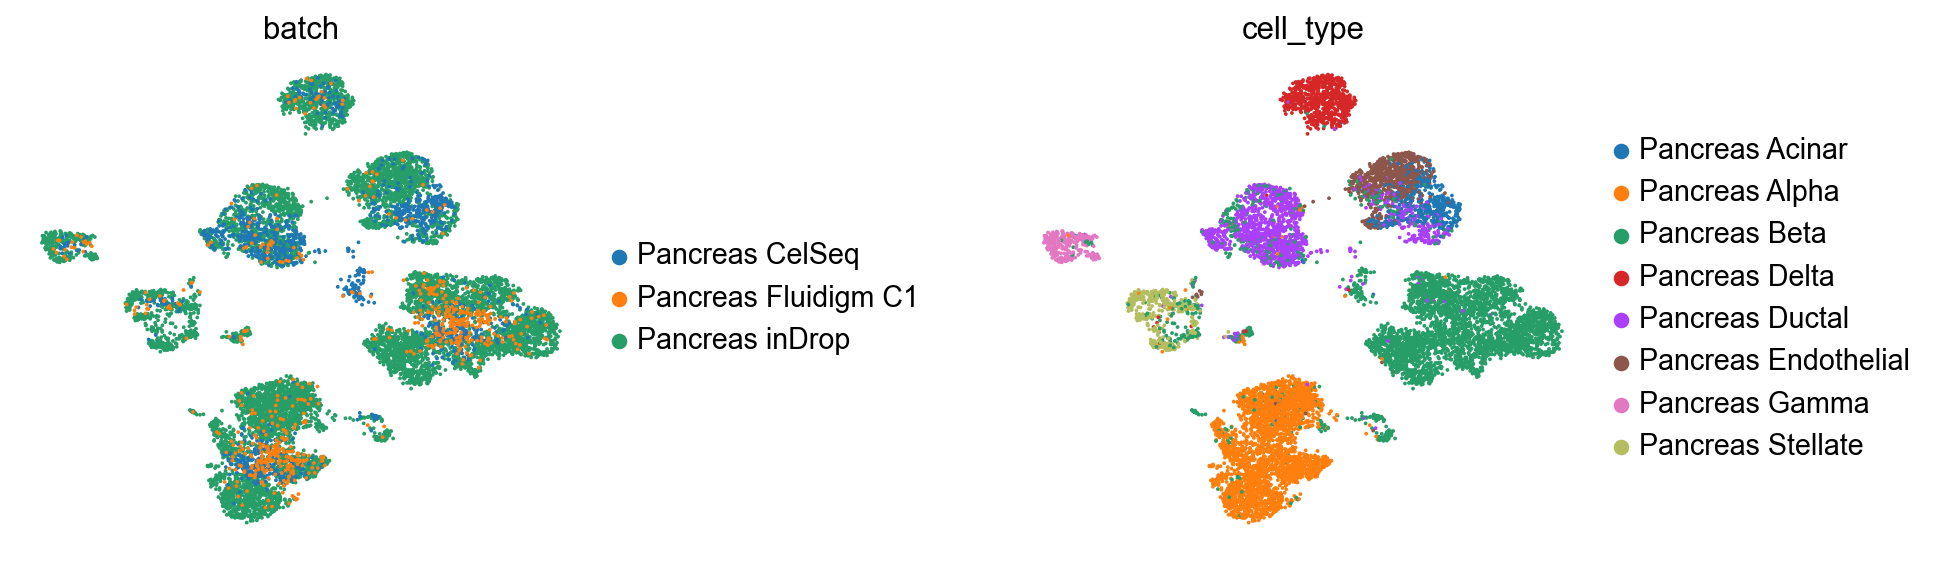

In [16]:
display_umap(reference_latent, color=['batch', 'cell_type'])

One can also compute the accuracy of the learned classifier

In [17]:
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.9427822032251797


After pretraining the model can be saved for later use

### Perform surgery on reference model and train on query dataset without cell type labels

If the cell types in 'target_adata' are equal to or a subset of the reference data cell types, one can just pass the adata without further preprocessing. It is also possible then to do semi-supervised training with scArches.

However if there are new cell types in 'target_adata' or if there is no '.obs' in the anndata for cell type labels (e.g. the data is unlabeled), one can only use scANVI in an unsupervised manner during surgery due to the nature of the classifier. 

In addition one has to preprocess 'target_adata' in the following way:

If there are new celltypes in there, save the original labels in other column and replace all labels with unlabeled category:

If there is no '.obs' column for cell types:

If 'target_adata' is in the right format, one can proceed with the surgery pipeline. Here we do the surgery unsupervised, but due to the overlapping cell types in query and reference data, one could also do supervised or semi-supervised surgery by setting the indices accordingly.

In [18]:
if load_existing_model and os.path.exists(surgery_dir):
    model = sca.models.SCANVI.load(dir_path=surgery_dir, adata=target_adata)
else:
    model = sca.models.SCANVI.load_query_data(
        target_adata,
        ref_dir,
        freeze_dropout = True,
    )
    model._unlabeled_indices = np.arange(target_adata.n_obs)
    model._labeled_indices = []
    print("Labelled Indices: ", len(model._labeled_indices))
    print("Unlabelled Indices: ", len(model._unlabeled_indices))
    model.train(
        max_epochs=100,
        plan_kwargs=dict(weight_decay=0.0),
        check_val_every_n_epoch=10,
    )
    model.save(surgery_dir, overwrite=True)

INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 5387 cells, 1000 vars, 5 batches, 
         8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


In [19]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

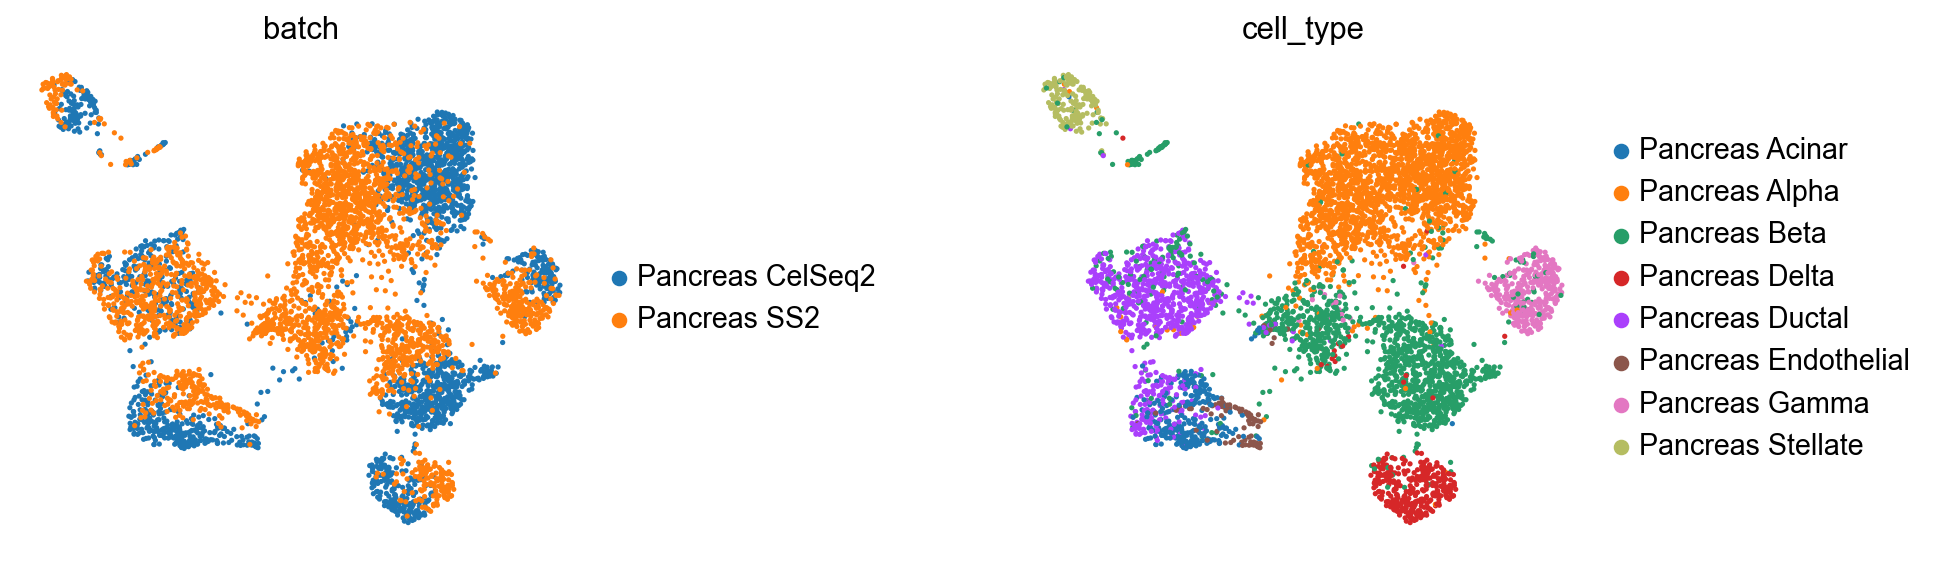

In [20]:
display_umap(query_latent, color=["batch", "cell_type"])

### Compute Accuracy of model classifier for query dataset and compare predicted and observed cell types

In [21]:
query_latent.obs['predictions'] = model.predict()
print("Acc: {}".format(np.mean(query_latent.obs.predictions == query_latent.obs.cell_type)))

Acc: 0.9018006311490625


/Users/chengfurui/Projects/polyphony/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  """


Text(0, 0.5, 'Observed')

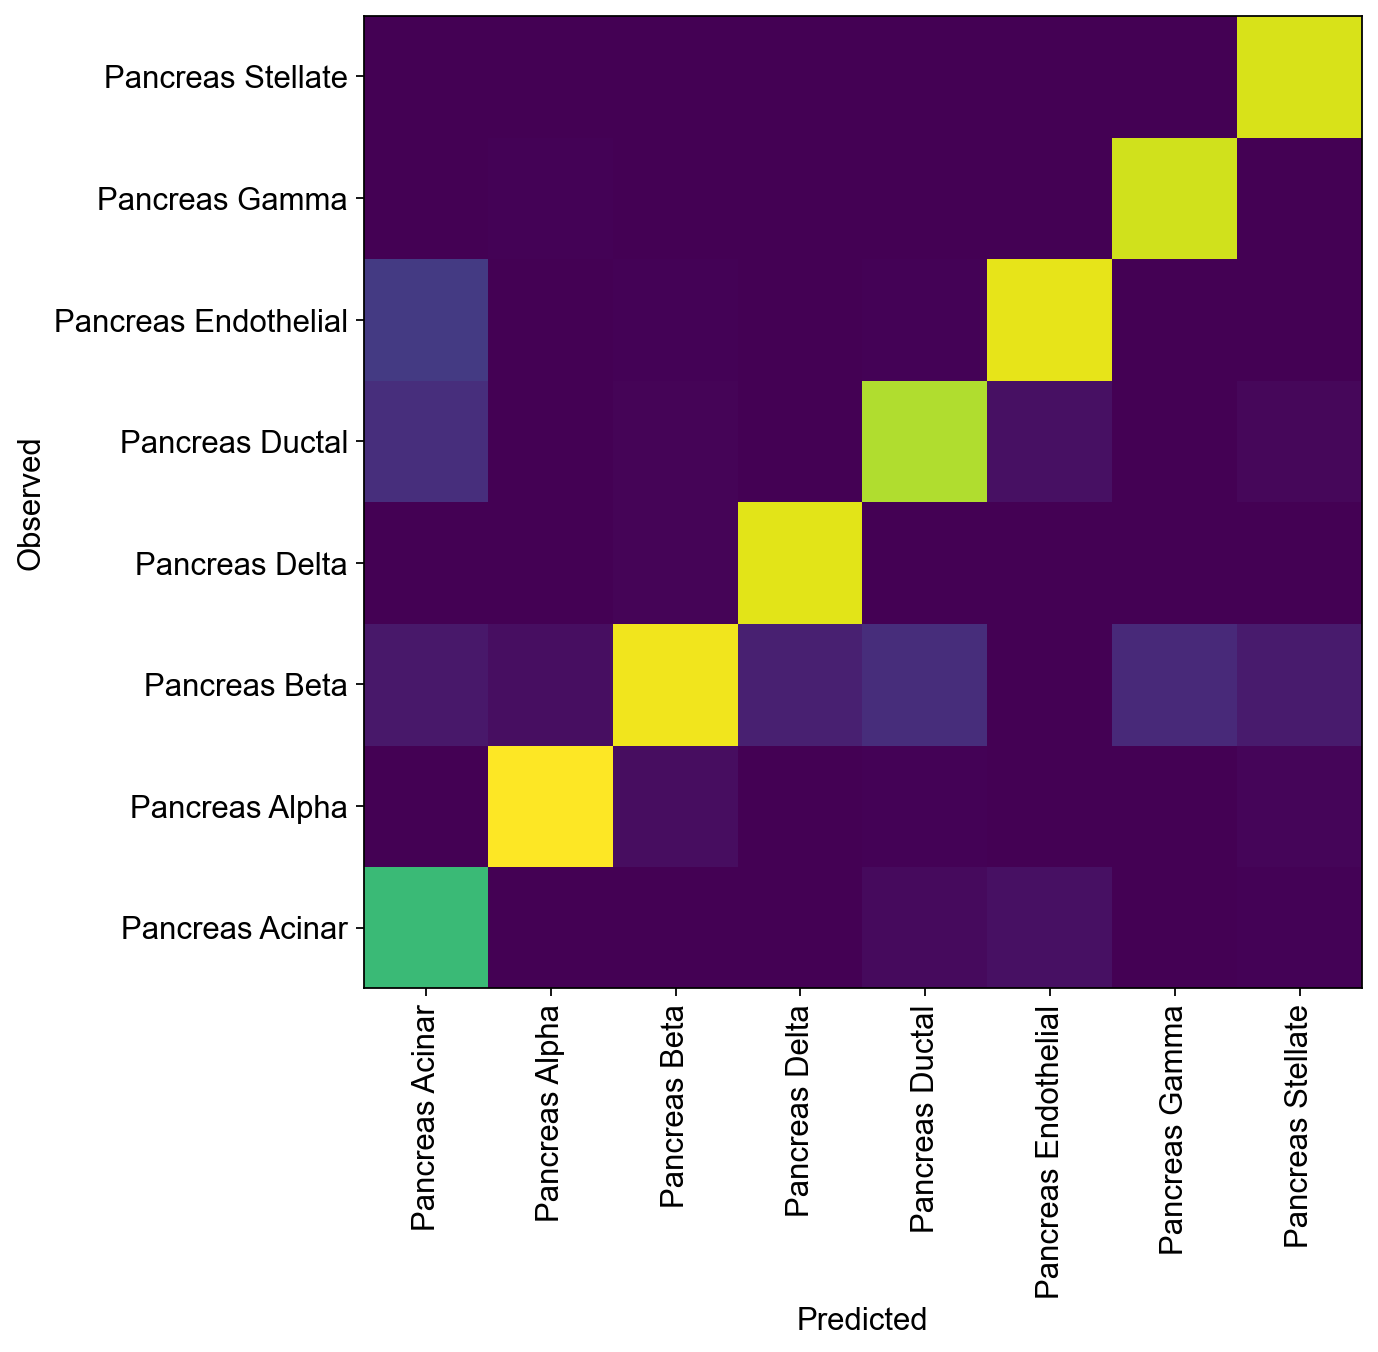

In [22]:
df = query_latent.obs.groupby(["cell_type", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

### Get latent representation of reference + query dataset and compute UMAP

In [23]:
adata_full = source_adata.concatenate(target_adata)
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata_full.obs[condition_key].tolist()

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 15681 cells, 1000 vars, 5 batches,
         8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

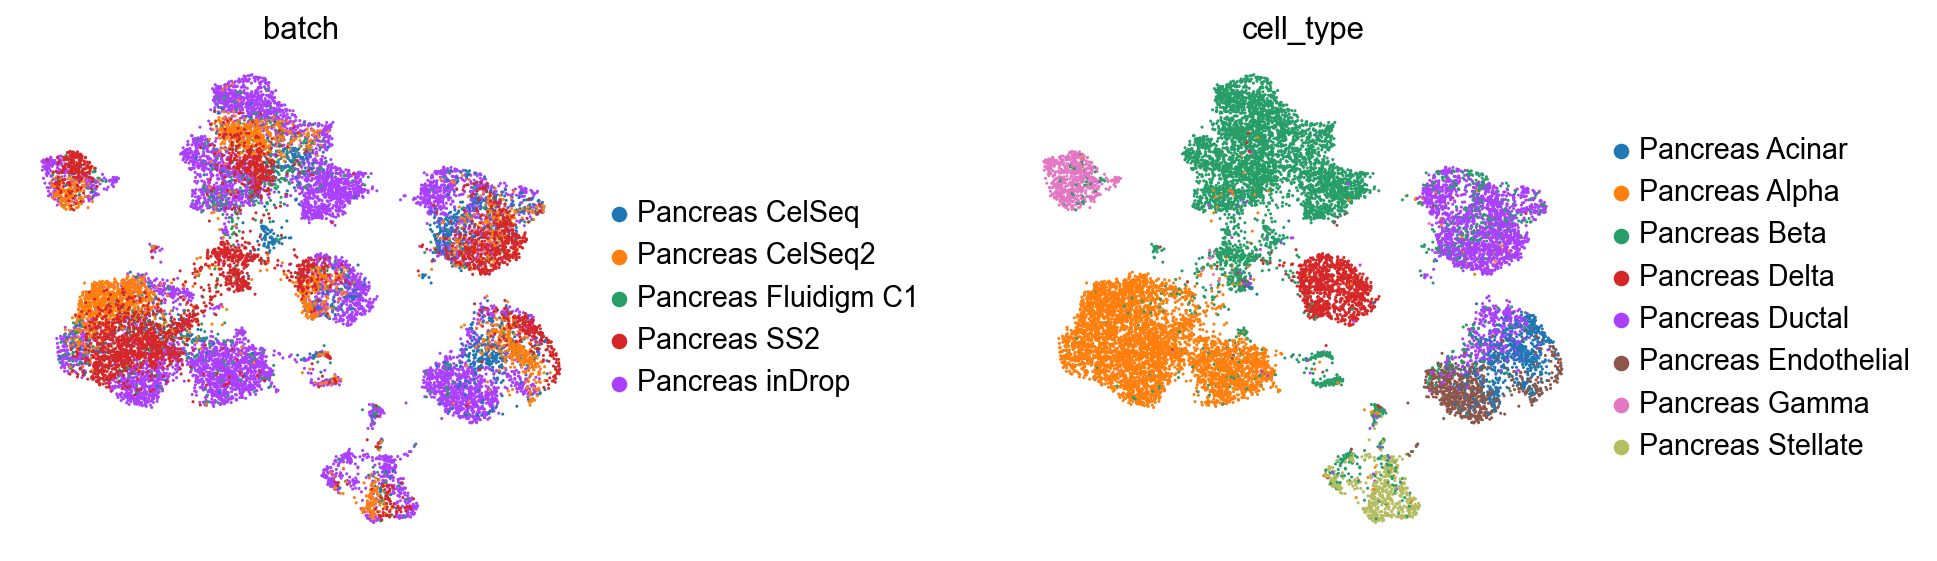

In [24]:
display_umap(full_latent, color=["batch", "cell_type"])

### Comparison of observed and predicted celltypes for reference + query dataset

In [25]:
full_latent.obs['predictions'] = model.predict(adata=adata_full)
print("Acc: {}".format(np.mean(full_latent.obs.predictions == full_latent.obs.cell_type)))

Acc: 0.9287035265608061


... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

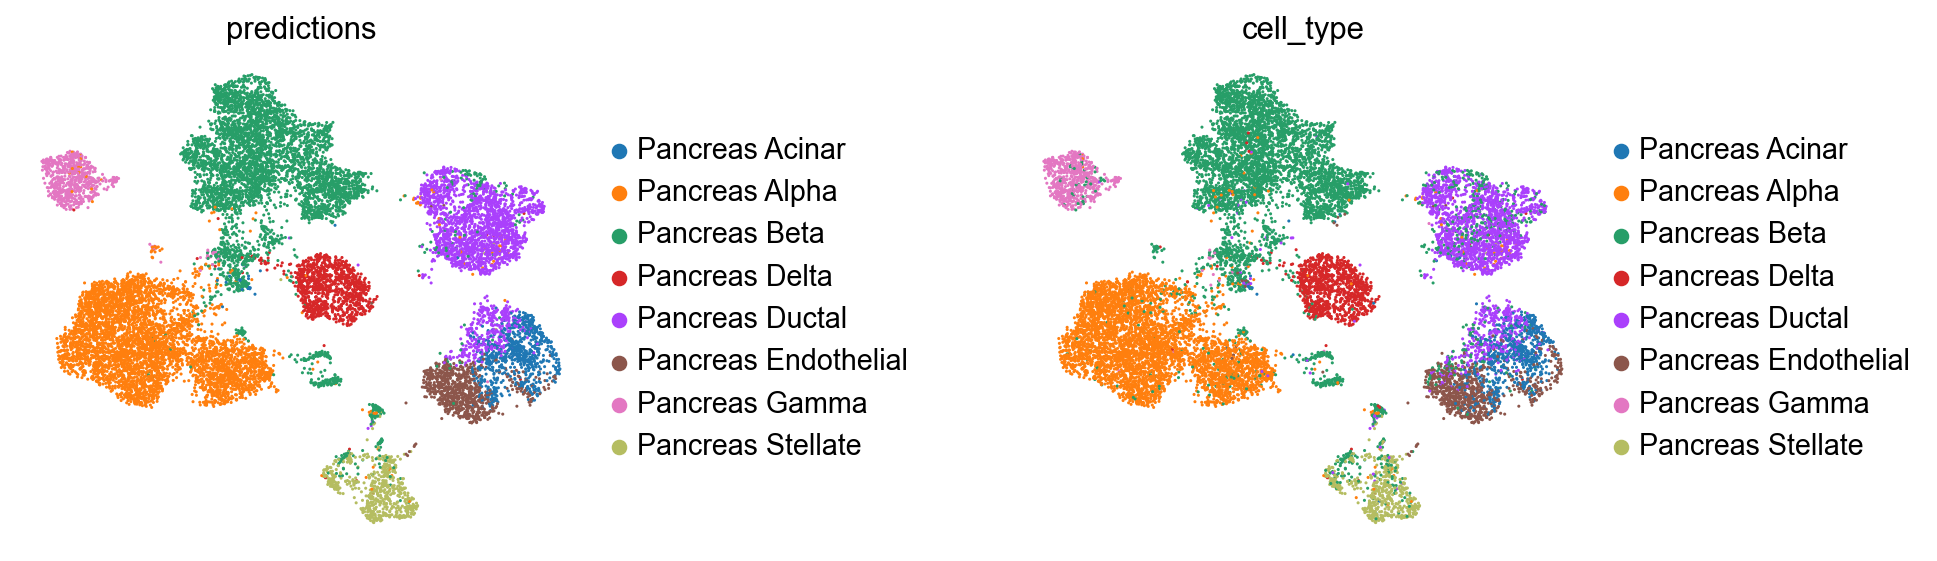

In [26]:
display_umap(full_latent, color=["predictions", "cell_type"])